<a href="https://colab.research.google.com/github/haleyyii0705/MELD/blob/master/final_versionB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import necessary libraries and select device

In [ ]:
import torch
import torch.nn as nn
from transformers import BertModel, BertTokenizer
from torch.optim import AdamW
from torch.optim.lr_scheduler import LambdaLR, StepLR
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
from torch.cuda.amp import autocast, GradScaler
import pandas as pd
from tqdm import tqdm

In [ ]:
# Device Selection (Automatically detect if a GPU is available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_amp = torch.cuda.is_available()

## MELD Dataset Loading and Preprocessing

In [ ]:
# Load MELD Data
!git clone https://github.com/declare-lab/MELD.git
train_df = pd.read_csv("/content/MELD/data/MELD/train_sent_emo.csv")
dev_df = pd.read_csv("/content/MELD/data/MELD/dev_sent_emo.csv")
test_df = pd.read_csv("/content/MELD/data/MELD/test_sent_emo.csv")

# Preprocess Data
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
num_labels = 7  # MELD has 7 emotion categories

# Define emotion label mapping to ensure order consistency
emotion_labels = {
    'neutral': 0,
    'surprise': 1,
    'fear': 2,
    'sadness': 3,
    'joy': 4,
    'disgust': 5,
    'anger': 6
}

def encode_data(df, tokenizer, max_len=128):
    inputs = tokenizer(df['Utterance'].tolist(),
                       padding='max_length',
                       truncation=True,
                       max_length=max_len,
                       return_tensors="pt")

    # Force label mapping according to `emotion_labels`
    labels = torch.tensor(df['Emotion'].map(emotion_labels).values)

    return inputs['input_ids'], inputs['attention_mask'], labels

# Preprocess data and ensure correct label order
train_inputs, train_masks, train_labels = encode_data(train_df, tokenizer)
valid_inputs, valid_masks, valid_labels = encode_data(dev_df, tokenizer)
test_inputs, test_masks, test_labels = encode_data(test_df, tokenizer)

# Create training, validation, and test datasets
train_dataset = TensorDataset(train_inputs, train_masks, train_labels)
val_dataset = TensorDataset(valid_inputs, valid_masks, valid_labels)
test_dataset = TensorDataset(test_inputs, test_masks, test_labels)

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


Cloning into 'MELD'...
remote: Enumerating objects: 493, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 493 (delta 10), reused 12 (delta 5), pack-reused 475 (from 1)
Receiving objects: 100% (493/493), 8.12 MiB | 17.69 MiB/s, done.
Resolving deltas: 100% (258/258), done.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

## Define the model: BERT + Bi-GRU + Attention

In [ ]:
# Define Bi-GRU + Attention Model
class BERT_BiGRU_Attention(nn.Module):
    def __init__(self, bert_model, num_labels, hidden_size=256):
        super(BERT_BiGRU_Attention, self).__init__()
        self.bert = bert_model
        self.gru = nn.GRU(input_size=768, hidden_size=hidden_size, num_layers=2, batch_first=True, bidirectional=True)
        self.attention = nn.MultiheadAttention(embed_dim=hidden_size * 2, num_heads=4, batch_first=True)
        self.layer_norm = nn.LayerNorm(hidden_size * 2)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_size * 2, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_states = outputs.last_hidden_state  # (batch_size, seq_len, hidden_dim)

        # Process contextual information using Bi-GRU
        gru_output, _ = self.gru(hidden_states)  # (batch_size, seq_len, hidden_size*2)

        # Self-attention layer
        attn_output, attn_weights = self.attention(gru_output, gru_output, gru_output)

        # Weighted pooling
        context_vector = torch.bmm(attn_weights, gru_output).mean(dim=1)  # (batch_size, hidden_size*2)

        # Classification layer
        logits = self.fc(self.dropout(context_vector))
        return logits


# Load BERT as an encoder
bert_model = BertModel.from_pretrained("bert-base-uncased")
model = BERT_BiGRU_Attention(bert_model, num_labels).to(device)  # Ensure the model is loaded onto GPU

# Training Parameters
optimizer = AdamW(model.parameters(), lr=5e-4, betas=(0.9, 0.999), weight_decay=0.01)
criterion = nn.CrossEntropyLoss()

def noam_lambda(step, warmup=10000):
    return min((step + 1) ** -0.5, (step + 1) * (warmup ** -1.5))

lr_scheduler = LambdaLR(optimizer, lr_lambda=lambda step: noam_lambda(step))


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

## Training

In [ ]:
# Ensure `use_amp` is defined
use_amp = torch.cuda.is_available()

# Define loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=3e-5,  # Reduce learning rate to prevent loss from decreasing too quickly
    weight_decay=1e-2  # Enhance L2 regularization to reduce overfitting
)

# Ensure `train_loader` and `val_loader` are correctly created
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  # Increase batch_size for better stability
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Training loop parameters
epochs = 10
scaler = GradScaler(enabled=use_amp) if use_amp else None
history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

# Adjust learning rate only at the epoch level
lr_scheduler = StepLR(optimizer, step_size=3, gamma=0.9)  # Decrease learning rate every 3 epochs

# Improve generalization: Increase Dropout
model.dropout = nn.Dropout(0.5)  # Increase Dropout to prevent overfitting

for epoch in range(epochs):
    # ========= Training Phase =========
    model.train()
    train_loss, train_correct, total_train = 0, 0, 0
    loop = tqdm(train_loader, leave=True, desc=f"Epoch {epoch+1} [Training]")

    for batch in loop:
        input_ids, attention_mask, labels = [x.to(device) for x in batch]
        labels = labels.long()
        optimizer.zero_grad()

        # Fix `autocast` syntax
        with autocast(enabled=use_amp):
            logits = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(logits.float(), labels)

        train_loss += loss.item()
        train_correct += (logits.argmax(dim=1) == labels).sum().item()
        total_train += labels.size(0)

        # Backpropagation (slightly reduce gradient clipping)
        if use_amp:
            scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Slightly reduce max_norm
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

        loop.set_postfix(loss=loss.item())

    train_acc = train_correct / total_train
    avg_train_loss = train_loss / len(train_loader)
    history["train_loss"].append(avg_train_loss)
    history["train_acc"].append(train_acc)

    # ========= Validation Phase =========
    model.eval()
    val_loss, val_correct, total_val = 0, 0, 0

    with torch.no_grad():
        loop = tqdm(val_loader, leave=True, desc=f"Epoch {epoch+1} [Validation]")
        for batch in loop:
            input_ids, attention_mask, labels = [x.to(device) for x in batch]
            labels = labels.long()

            with autocast(enabled=use_amp):  # Ensure val_loss calculation is consistent with training
                logits = model(input_ids=input_ids, attention_mask=attention_mask)
                loss = criterion(logits.float(), labels)

            val_loss += loss.item()
            val_correct += (logits.argmax(dim=1) == labels).sum().item()
            total_val += labels.size(0)

            loop.set_postfix(loss=loss.item())

    val_acc = val_correct / total_val
    avg_val_loss = val_loss / len(val_loader)
    history["val_loss"].append(avg_val_loss)
    history["val_acc"].append(val_acc)

    print(f"\nEpoch {epoch+1}: Train Loss={avg_train_loss:.4f}, Train Acc={train_acc:.4f}, Val Loss={avg_val_loss:.4f}, Val Acc={val_acc:.4f}\n")

    # Update learning rate only at the end of each epoch
    lr_scheduler.step()

print("Training completed!")


<ipython-input-5-a8b9245e62e0>:19: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=use_amp) if use_amp else None
Epoch 1 [Training]:   0%|          | 0/313 [00:00<?, ?it/s]<ipython-input-5-a8b9245e62e0>:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
Epoch 1 [Validation]:   0%|          | 0/35 [00:00<?, ?it/s]<ipython-input-5-a8b9245e62e0>:76: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):  # Ensure val_loss calculation is consistent with training
Epoch 1 [Validation]: 100%|██████████| 35/35 [00:02<00:00, 16.15it/s, loss=1.86]



Epoch 1: Train Loss=1.2627, Train Acc=0.5820, Val Loss=1.1845, Val Acc=0.6078



Epoch 2 [Validation]: 100%|██████████| 35/35 [00:02<00:00, 16.66it/s, loss=1.53]



Epoch 2: Train Loss=1.0509, Train Acc=0.6552, Val Loss=1.1439, Val Acc=0.6159



Epoch 3 [Validation]: 100%|██████████| 35/35 [00:02<00:00, 16.81it/s, loss=1.68]



Epoch 3: Train Loss=0.9438, Train Acc=0.6915, Val Loss=1.1543, Val Acc=0.6150



Epoch 4 [Validation]: 100%|██████████| 35/35 [00:02<00:00, 16.85it/s, loss=1.84]



Epoch 4: Train Loss=0.8185, Train Acc=0.7356, Val Loss=1.1936, Val Acc=0.6186



Epoch 5 [Validation]: 100%|██████████| 35/35 [00:02<00:00, 16.78it/s, loss=1.36]



Epoch 5: Train Loss=0.7135, Train Acc=0.7703, Val Loss=1.2118, Val Acc=0.6168



Epoch 6 [Validation]: 100%|██████████| 35/35 [00:02<00:00, 17.04it/s, loss=1.57]



Epoch 6: Train Loss=0.6052, Train Acc=0.8129, Val Loss=1.2751, Val Acc=0.6141



Epoch 7 [Validation]: 100%|██████████| 35/35 [00:02<00:00, 16.82it/s, loss=1.68]



Epoch 7: Train Loss=0.4956, Train Acc=0.8484, Val Loss=1.4028, Val Acc=0.5996



Epoch 8 [Validation]: 100%|██████████| 35/35 [00:02<00:00, 16.80it/s, loss=1.56]



Epoch 8: Train Loss=0.4006, Train Acc=0.8781, Val Loss=1.4817, Val Acc=0.5933



Epoch 9 [Validation]: 100%|██████████| 35/35 [00:02<00:00, 16.69it/s, loss=1.58]



Epoch 9: Train Loss=0.3776, Train Acc=0.8844, Val Loss=1.5320, Val Acc=0.5951



Epoch 10 [Validation]: 100%|██████████| 35/35 [00:02<00:00, 16.74it/s, loss=1.81]


Epoch 10: Train Loss=0.3612, Train Acc=0.8882, Val Loss=1.6659, Val Acc=0.5915

Training completed!


## Test on testset

In [ ]:
from sklearn.metrics import accuracy_score, f1_score
import torch
from tqdm import tqdm

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for batch in tqdm(test_loader):
        input_ids, attention_mask, labels = [x.to(device) for x in batch]

        with torch.amp.autocast(device_type="cuda"):
            logits = model(input_ids=input_ids, attention_mask=attention_mask)

        preds = torch.argmax(logits, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

# Compute Accuracy and F1-score
acc = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average="weighted")

print(f"Test Accuracy: {acc:.4f}")
print(f"Test F1-Score: {f1:.4f}")


100%|██████████| 164/164 [00:05<00:00, 31.20it/s]

Test Accuracy: 0.6207
Test F1-Score: 0.5948


## Visualization

### Loss and Accuracy in training process

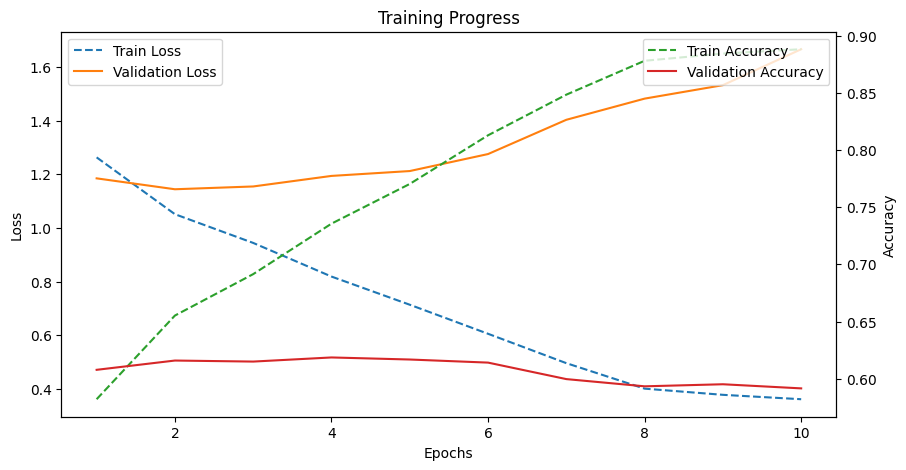

In [ ]:
import matplotlib.pyplot as plt

def plot_training_progress(history, title="Training Progress"):
    epochs = range(1, len(history["train_loss"]) + 1)

    fig, ax1 = plt.subplots(figsize=(10,5))

    # Plot the Loss curve
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.plot(epochs, history["train_loss"], label='Train Loss', color='tab:blue', linestyle='dashed')
    ax1.plot(epochs, history["val_loss"], label='Validation Loss', color='tab:orange')
    ax1.legend(loc='upper left')

    # Plot the Accuracy curve (using the right y-axis)
    ax2 = ax1.twinx()
    ax2.set_ylabel('Accuracy')
    ax2.plot(epochs, history["train_acc"], label='Train Accuracy', color='tab:green', linestyle='dashed')
    ax2.plot(epochs, history["val_acc"], label='Validation Accuracy', color='tab:red')
    ax2.legend(loc='upper right')

    plt.title(title)
    plt.show()

# Call the visualization function
plot_training_progress(history)


### Normalized confusion matrix

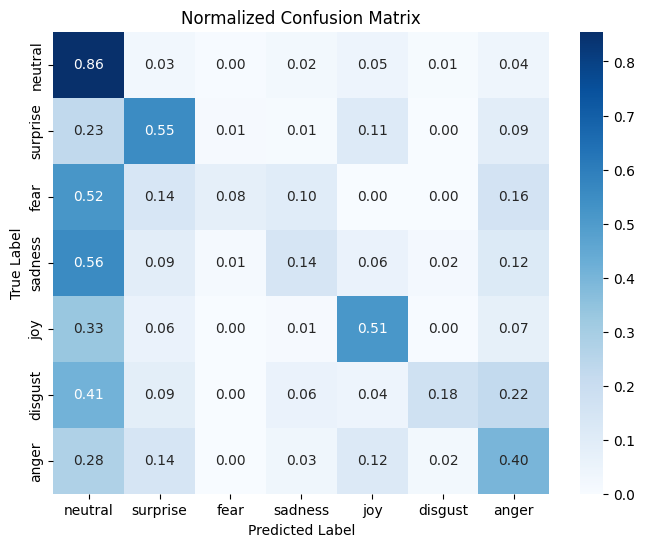

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_normalized_confusion_matrix(y_true, y_pred, labels, title="Normalized Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.show()

plot_normalized_confusion_matrix(all_labels, all_preds, labels=emotion_labels, title="Normalized Confusion Matrix")
